In [1]:
import keras
import numpy as np
from keras.datasets import mnist
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = mnist.load_data()

2023-04-12 16:47:25.916927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 16:47:26.003271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/tf2.11/lib::/usr/lib/nvidia:/usr/local/cuda/lib64
2023-04-12 16:47:26.003284: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


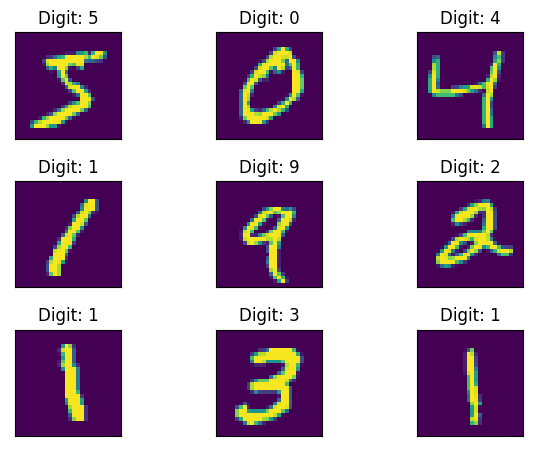

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i])
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])

In [3]:
print(X_train.shape)

(60000, 28, 28)


In [4]:
from keras.utils import to_categorical

# gotta include the color channel
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# has to be floats for tensors 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize pixel values between 0 and 1
X_train /= 255
X_test /= 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


history = model.fit(X_train, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

2023-04-12 16:47:28.368819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 16:47:28.369473: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/tf2.11/lib::/usr/lib/nvidia:/usr/local/cuda/lib64
2023-04-12 16:47:28.369708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/tf2.11/lib::/usr/lib/nvidia:/usr/local/cuda/lib64
2023-04-12 16:47:28.369926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader

375/375 [==============================] - 7s 16ms/step - loss: 0.4724 - accuracy: 0.8597 - val_loss: 0.1278 - val_accuracy: 0.9634
Epoch 2/3
375/375 [==============================] - 6s 16ms/step - loss: 0.1995 - accuracy: 0.9432 - val_loss: 0.0855 - val_accuracy: 0.9758
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0710 - accuracy: 0.9771
Test loss: 0.07103051245212555
Test accuracy: 0.9771000146865845


313/313 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'actual: 6, predicted: 6')

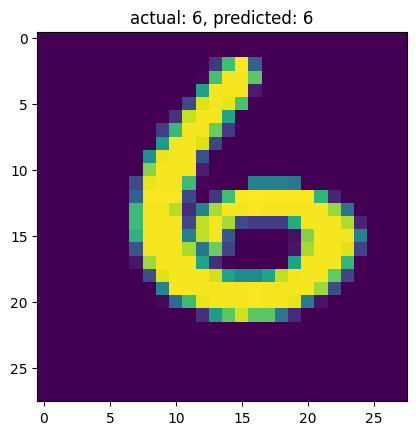

In [6]:
randint = np.random.randint(len(X_test))
plt.imshow(X_test[randint])
plt.title(f'actual: {np.argmax(y_test[randint])}, predicted: {np.argmax(model.predict(X_test)[randint])}')

In [7]:
#?fast_gradient_method

313/313 [==============================] - 1s 2ms/step


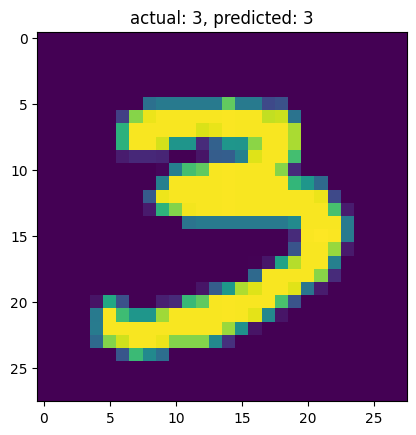

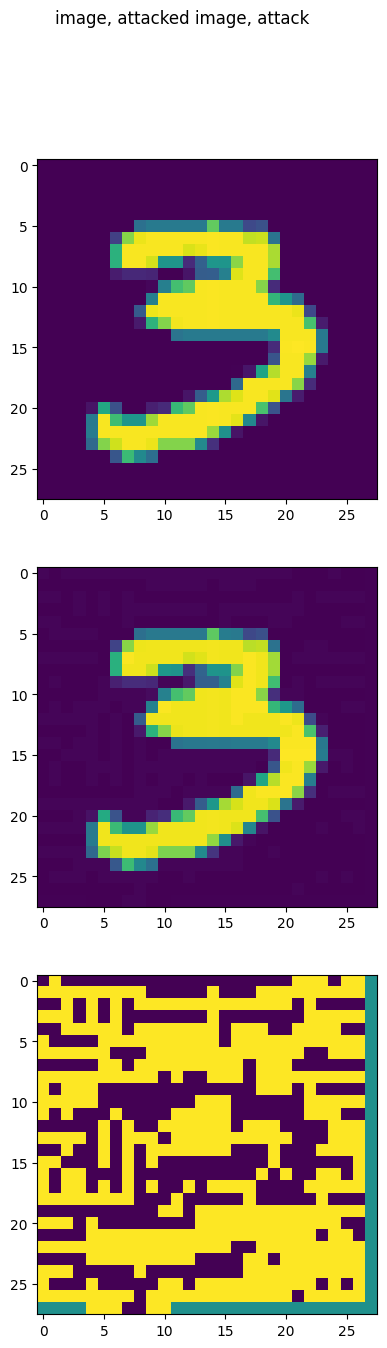

In [8]:
randint = np.random.randint(len(X_test))
plt.imshow(X_test[randint])
plt.title(f'actual: {np.argmax(y_test[randint])}, predicted: {np.argmax(model.predict(X_test)[randint])}')
def attack(image,image_label):
    
    target_class = np.random.randint(0,10)
    while target_class == image_label:
        target_class = np.random.randint(0,10)

    # max iter high to ensure hac, increase eps to decrease time taken
    # max iter low & eps low to apply subtle attack
    max_iter = 1
    eps = 0.007
    target_class_as_array = np.array([target_class])
    image_array = np.array([image])

    im_hacked = fast_gradient_method(model,
                                     image_array,
                                     eps,
                                     np.inf,
                                     y=target_class_as_array,
                                     targeted=True)

    current_confidence = 0.0

    i = 1
    im_hacked = fast_gradient_method(model,image_array,eps,np.inf,y=target_class_as_array,targeted=True)
    pred_class = model.predict(im_hacked,verbose=0)

    #print(f'{image_label == np.argmax(pred_class)} and {(i < max_iter)}/ iter: 0, act_class: {image_label}, pred_class: {np.argmax(pred_class)}, confidence: {np.max(pred_class)}')

    while image_label == np.argmax(pred_class) and (i < max_iter):
        im_hacked = fast_gradient_method(model,im_hacked,eps,np.inf,y=target_class_as_array,targeted=True)
        pred_class = model.predict(im_hacked,verbose=0)
        #print(f'{image_label == np.argmax(pred_class)} and {(i < max_iter)}/ iter: {i}, act_class: {image_label}, pred_class: {np.argmax(pred_class)}, confidence: {np.max(pred_class)}')

        current_confidence = np.max(pred_class)
        i += 1
    
    
    return im_hacked


im_hacked = attack(X_test[randint],np.argmax(y_test[randint]))
fig, axs = plt.subplots(3,figsize=(20,15))
fig.suptitle('image, attacked image, attack')
axs[0].imshow(X_test[randint])
axs[1].imshow(im_hacked[0])
axs[2].imshow(X_test[randint]-im_hacked[0])

6


<Figure size 640x480 with 0 Axes>

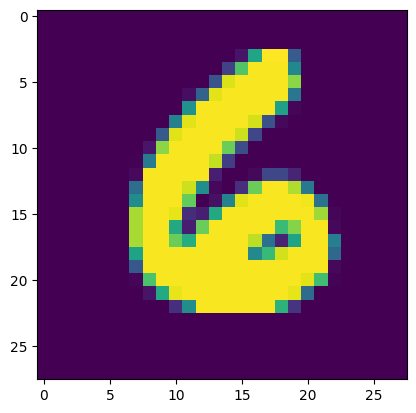

<Figure size 640x480 with 0 Axes>

In [9]:
total = 500
attack_indices = np.random.choice(len(X_train), size=total, replace=False)

attack_indices_1 = attack_indices[:int(total/2)]
attack_indices_2 = attack_indices[int(total/2):]

X_train_safe = X_train[attack_indices_2]
X_train_to_attack = X_train[attack_indices_1]

print(np.argmax(y_train[attack_indices[0]]))
plt.imshow(X_train_to_attack[0])
plt.figure()

In [10]:
X_train_attacked = []
for i in range(len(X_train_to_attack)):
    print(i)
    attacked = attack(X_train_to_attack[i],np.argmax(y_train[attack_indices[i]]))
    X_train_attacked.append(attacked)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [11]:
X_train_attacked = np.array(X_train_attacked)

print(type(X_train_attacked))
print(type(X_train_safe))
print(len(X_train_safe))
print(X_train_safe.shape)
print(X_train_attacked.shape)

X_train_attacked_squeezed = np.squeeze(X_train_attacked, axis=1)
print(X_train_attacked_squeezed.shape)

labels_non_attacked = [0] * len(X_train_safe)
labels_attacked = [1] * len(X_train_attacked)

X_train_combined = np.concatenate((X_train_safe, X_train_attacked_squeezed), axis=0)

y_train_combined = np.concatenate((labels_non_attacked, labels_attacked), axis=0)

np.random.seed(42)  # Set random seed for consistent shuffle
shuffle_indices = np.random.permutation(len(X_train_combined))
X_train_combined_shuffled = X_train_combined[shuffle_indices]
y_train_combined_shuffled = y_train_combined[shuffle_indices]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
250
(250, 28, 28, 1)
(250, 1, 28, 28, 1)
(250, 28, 28, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_train_combined_shuffled, 
                                                    y_train_combined_shuffled, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [13]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_2 = model.fit(X_train,y_train,epochs=200,validation_split=0.2)

Epoch 1/200
12/12 [==============================] - 1s 21ms/step - loss: 0.7088 - accuracy: 0.4778 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 2/200
12/12 [==============================] - 0s 13ms/step - loss: 0.6897 - accuracy: 0.5139 - val_loss: 0.6893 - val_accuracy: 0.5333
Epoch 3/200
12/12 [==============================] - 0s 13ms/step - loss: 0.6856 - accuracy: 0.5667 - val_loss: 0.7030 - val_accuracy: 0.5111
Epoch 4/200
12/12 [==============================] - 0s 13ms/step - loss: 0.6812 - accuracy: 0.5611 - val_loss: 0.7011 - val_accuracy: 0.5111
Epoch 5/200
12/12 [==============================] - 0s 13ms/step - loss: 0.6857 - accuracy: 0.5778 - val_loss: 0.6962 - val_accuracy: 0.5444
Epoch 6/200
12/12 [==============================] - 0s 13ms/step - loss: 0.6694 - accuracy: 0.6056 - val_loss: 0.6959 - val_accuracy: 0.5222
Epoch 7/200
12/12 [==============================] - 0s 13ms/step - loss: 0.6730 - accuracy: 0.5889 - val_loss: 0.6986 - val_accuracy: 0.5444
Epoch 

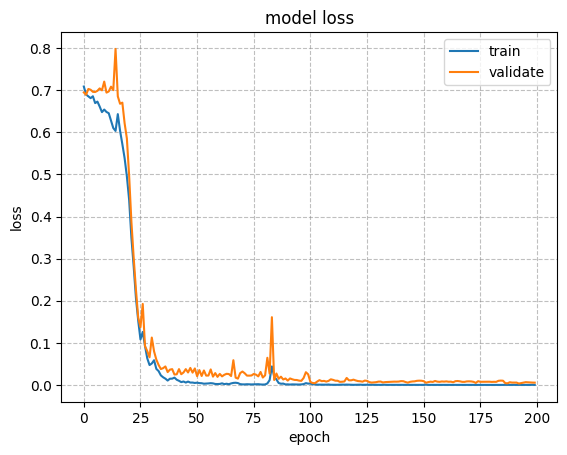

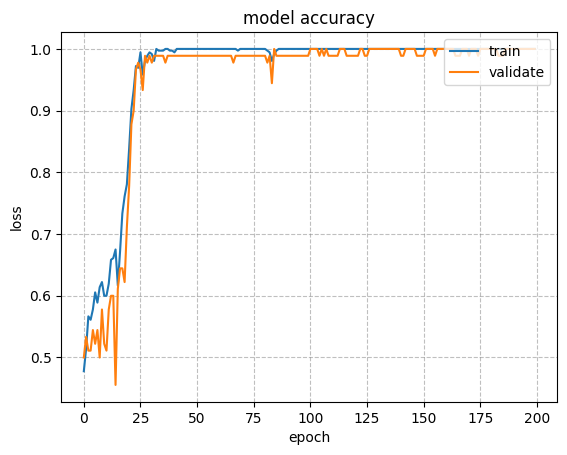

<Figure size 640x480 with 0 Axes>

In [14]:
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()
plt.clf()

# summarize history for acc
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()
plt.clf()

In [15]:
pred = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [16]:
y_pred_rounded = np.round(pred).astype(int)

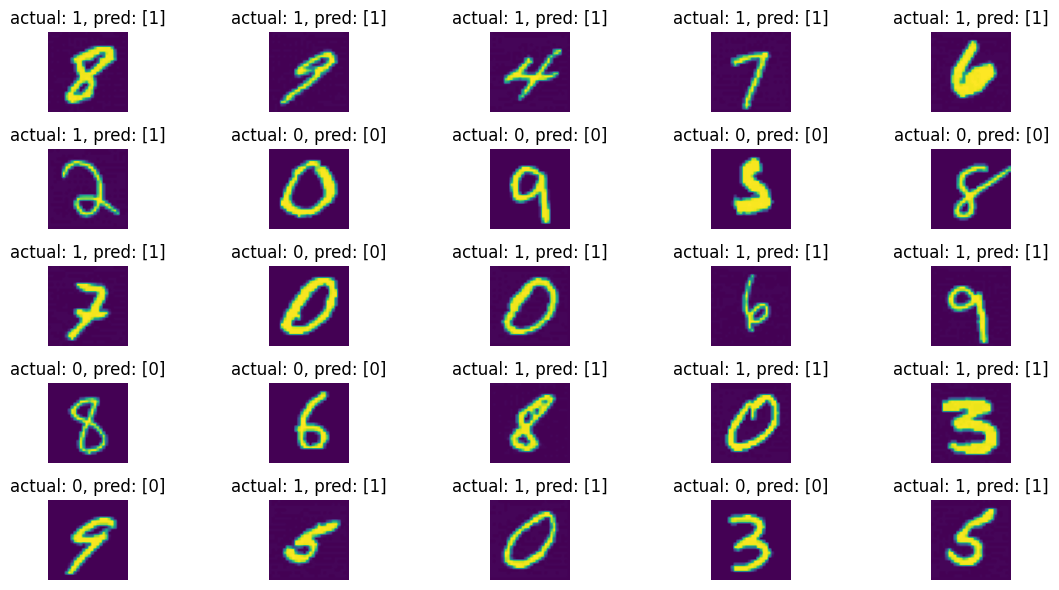

In [17]:
import matplotlib.pyplot as plt

rows = 5
cols = 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

for i in range(rows):
    for j in range(cols):
        index = 5 * i + j
        ax[i][j].imshow(X_test[index])
        ax[i][j].set_title(f'actual: {y_test[index]}, pred: {y_pred_rounded[index]}')
        ax[i][j].axis('off')

plt.tight_layout()
plt.show()

In [18]:
# I'm thinking about making the attack more subtle, 
# so I can increase the amount of attacked images and make classification harder, 
# as well as potentially making synthetic attacked images depending on the time more subtle attacks take to perform.

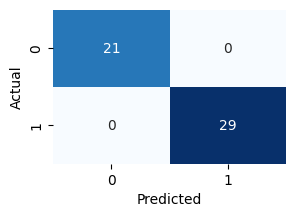

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(3,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()